In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import squidpy as sq
from skimage import io
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

import matplotlib
from matplotlib import cm, colors
from matplotlib.pyplot import rc_context

sc.set_figure_params(format="png")
import anndata as ad
import seaborn as sns
from kneed import KneeLocator
from matplotlib.ticker import MaxNLocator
from PIL import Image
from scipy import ndimage
from skimage import exposure, measure, morphology
from sklearn.cluster import MiniBatchKMeans
import napari
import math


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

In [22]:
adata_path = data_dir / 'metadata' / f"combined_LN.h5ad"
adata = ad.read_h5ad(adata_path)


In [23]:
all_donor = [
    "LN Donor A",
    "LN Donor E",
]
donor = all_donor[1]

In [24]:
adata = adata[(adata.obs.Dataset == donor),:]

# Import data

In [25]:
from joblib import Parallel, delayed

def get_imgs(file_path, name):
    f = h5py.File(file_path, "r")
    imgs = f[name]
    labels = list(f[name].attrs["labels"])
    return imgs, labels


def contrast_streching(img):
    p2, p98 = np.percentile(img, (0.5, 99.5))
    return exposure.rescale_intensity(
        img, in_range=(p2, p98), out_range=(0, 255)
    ).astype(np.uint8)


def get_img_subset(imgs, markers, labels):
    imgs_subset = []
    for marker in markers:
        idx = labels.index(marker)
        imgs_subset.append(contrast_streching(imgs[idx]))
    return np.stack(imgs_subset, axis=2)


def get_img_size(roi_dict, size=1000):
    row_max = 0
    col_max = 0
    for k, v in roi_dict.items():
        row_max = max(row_max, v[0])
        col_max = max(col_max, v[1])
    return row_max + size, col_max + size

def read_img(path):
    return contrast_streching(skimage.io.imread(path))


def joblib_loop(task, pics):
    return Parallel(n_jobs=20)(delayed(task)(i) for i in pics)

In [44]:
# Format row, col
arrangement = {
    "LN Donor A": {
        # 1: [0, 1000],
        # 2: [0, 2000],
        # 3: [1000, 0],
        # 4: [1000, 1000],
        # 5: [1000, 2000],
        # 6: [1000, 3000],
        # 7: [2000, 0],
        # 8: [2000, 1000],
        # 9: [2000, 2000],
        # 10: [2000, 3000],
        # 11: [3000, 0],
        # 12: [3000, 1000],
        # 13: [3000, 2000],
        # 14: [3000, 3000],
        15: [0, 1000],
        16: [0, 2000],
    },
    "LN Donor E": {
        # 1: [1000, 0],
        # 2: [1000, 1000],
        3: [1000, 0],
        # 4: [1000, 1000],
        # 5: [1000, 4000],
        # 6: [1000, 5000],
        # 7: [1000, 6000],
        # 8: [1000, 7000],
        # 9: [1000, 8000],
        # 10: [0, 0],
        # 11: [0, 1000],
        12: [0, 0],
        # 13: [0, 1000],
        # 14: [0, 4000],
    },
}

In [45]:
h5_data = p_dir / "data" / "h5" / f"{donor}.hdf5"
size = 1000

# Create combined images
y_max, x_max = get_img_size(arrangement[donor])
img_combined_multiplex = np.zeros((26, y_max, x_max), dtype=np.uint8)

ROIs = [i for i in range(1, 21)]
for roi in tqdm(ROIs, total=len(ROIs)):
    if roi not in arrangement[donor].keys():
        continue

    # Read imgs
    imgs, labels = get_imgs(h5_data, str(roi))
    imgs = joblib_loop(contrast_streching, imgs)
    imgs = np.stack(imgs)
    
    # Get offset
    y = arrangement[donor][roi][0]
    x = arrangement[donor][roi][1]
    img_combined_multiplex[:, y : y + size, x : x + size] = imgs[:,:size, :size]

  0%|          | 0/20 [00:00<?, ?it/s]

In [46]:
napari.view_image(img_combined_multiplex, channel_axis=0, name=labels, visible=False)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 999.5, 499.5), zoom=0.45694999999999997, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 2000.0, 1.0), (0.0, 1000.0, 1.0)), current_step=(1000, 500), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'CD38' at 0x132cd0306a0>, <Image layer 'Vimentin' at 0x132cebdb580>, <Image layer 'CD21' at 0x132cec47e50>, <Image layer 'BCL6' at 0x132cf0903d0>, <Image layer 'ICOS1' at 0x132d00e7910>, <Image layer 'CD11b' at 0x132d017bfd0>, <Image layer 'CD86' at 0x132d0214430>, <Image layer 'CXCR4' at 0x132d02aa970>, <Image layer 'CD11c' at 0x132d0338eb0>, <Image layer 'FoxP3' at 0x132d03df430>, <Image layer 'CD4' at 0x132d0474970>, <Image layer 'CD138' at 0x

In [47]:
adata = adata[adata.obs.ROI.isin(arrangement[donor].keys()),:]

In [48]:
coords = adata.obsm['spatial']
coords = np.asarray(coords).astype(int)
r = coords[:,1]
c = coords[:,0]

df_intensity = pd.DataFrame(adata.X, columns=adata.var_names)
df_intensity['Y'] = coords[:,1]
df_intensity['X'] = coords[:,0]

In [49]:
df_intensity

,CD38,Vimentin,CD21,BCL6,ICOS1,CD11b,CD11c,FoxP3,CD4,CD138,...,PD1,CD83,Ki67,COL1,CD3,CD27,EZH2,H3K27me3,Y,X
0,2.053161,2.199653,-0.411120,0.0,-0.594467,-0.097045,1.158726,-0.160321,-0.120553,2.502615,...,-0.072843,0.0,-0.233042,1.969251,2.485026,1.805867,-0.166244,0.368662,1003,2327
1,0.700542,-0.756324,-0.434418,0.0,-0.594467,-0.097045,-0.346591,-0.160321,-0.392484,-0.644707,...,-0.072843,0.0,-0.233042,-0.093389,-0.093311,0.472220,-0.166244,2.464814,1004,2723
2,-0.585723,-1.034162,-0.531415,0.0,-0.594467,-0.097045,-1.416421,-0.160321,0.884333,-0.644707,...,-0.072843,0.0,-0.233042,-0.653101,0.833167,-0.123766,-0.166244,-0.916134,1002,2100
3,-0.585723,-0.856130,-0.531415,0.0,-0.594467,-0.097045,-1.319372,-0.160321,-0.867074,-0.644707,...,-0.072843,0.0,-0.233042,-0.653101,-0.013551,-0.223884,-0.166244,-0.749475,1004,2204
4,1.522889,-0.657101,-0.531415,0.0,-0.594467,-0.097045,-1.011326,-0.160321,2.508508,-0.644707,...,-0.072843,0.0,2.259874,-0.522798,2.261731,0.359518,-0.166244,-1.451249,1002,2532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32317,2.091678,-0.184151,-0.531415,0.0,2.564150,-0.097045,0.824045,-0.160321,0.456252,-0.061256,...,-0.072843,0.0,-0.233042,-0.536036,1.868080,1.402016,-0.166244,0.660122,993,2516
32318,0.436945,0.847816,-0.531415,0.0,-0.594467,-0.097045,0.198341,-0.160321,-0.823406,-0.644707,...,-0.072843,0.0,-0.233042,0.260095,-0.603019,-0.880210,-0.166244,-0.124613,994,2846
32319,-0.585723,0.081312,-0.531415,0.0,-0.594467,-0.097045,0.835566,-0.160321,1.715913,-0.644707,...,-0.072843,0.0,-0.233042,-0.471000,1.577676,-0.880210,-0.166244,-0.190690,995,2850
32320,-0.585723,2.605373,2.431190,0.0,-0.594467,-0.097045,1.288494,-0.160321,0.802911,-0.285660,...,-0.072843,0.0,-0.233042,0.787697,-1.019945,-0.880210,-0.166244,1.656984,995,2898


In [50]:
markers_list = df_intensity.columns.tolist()[:-2]

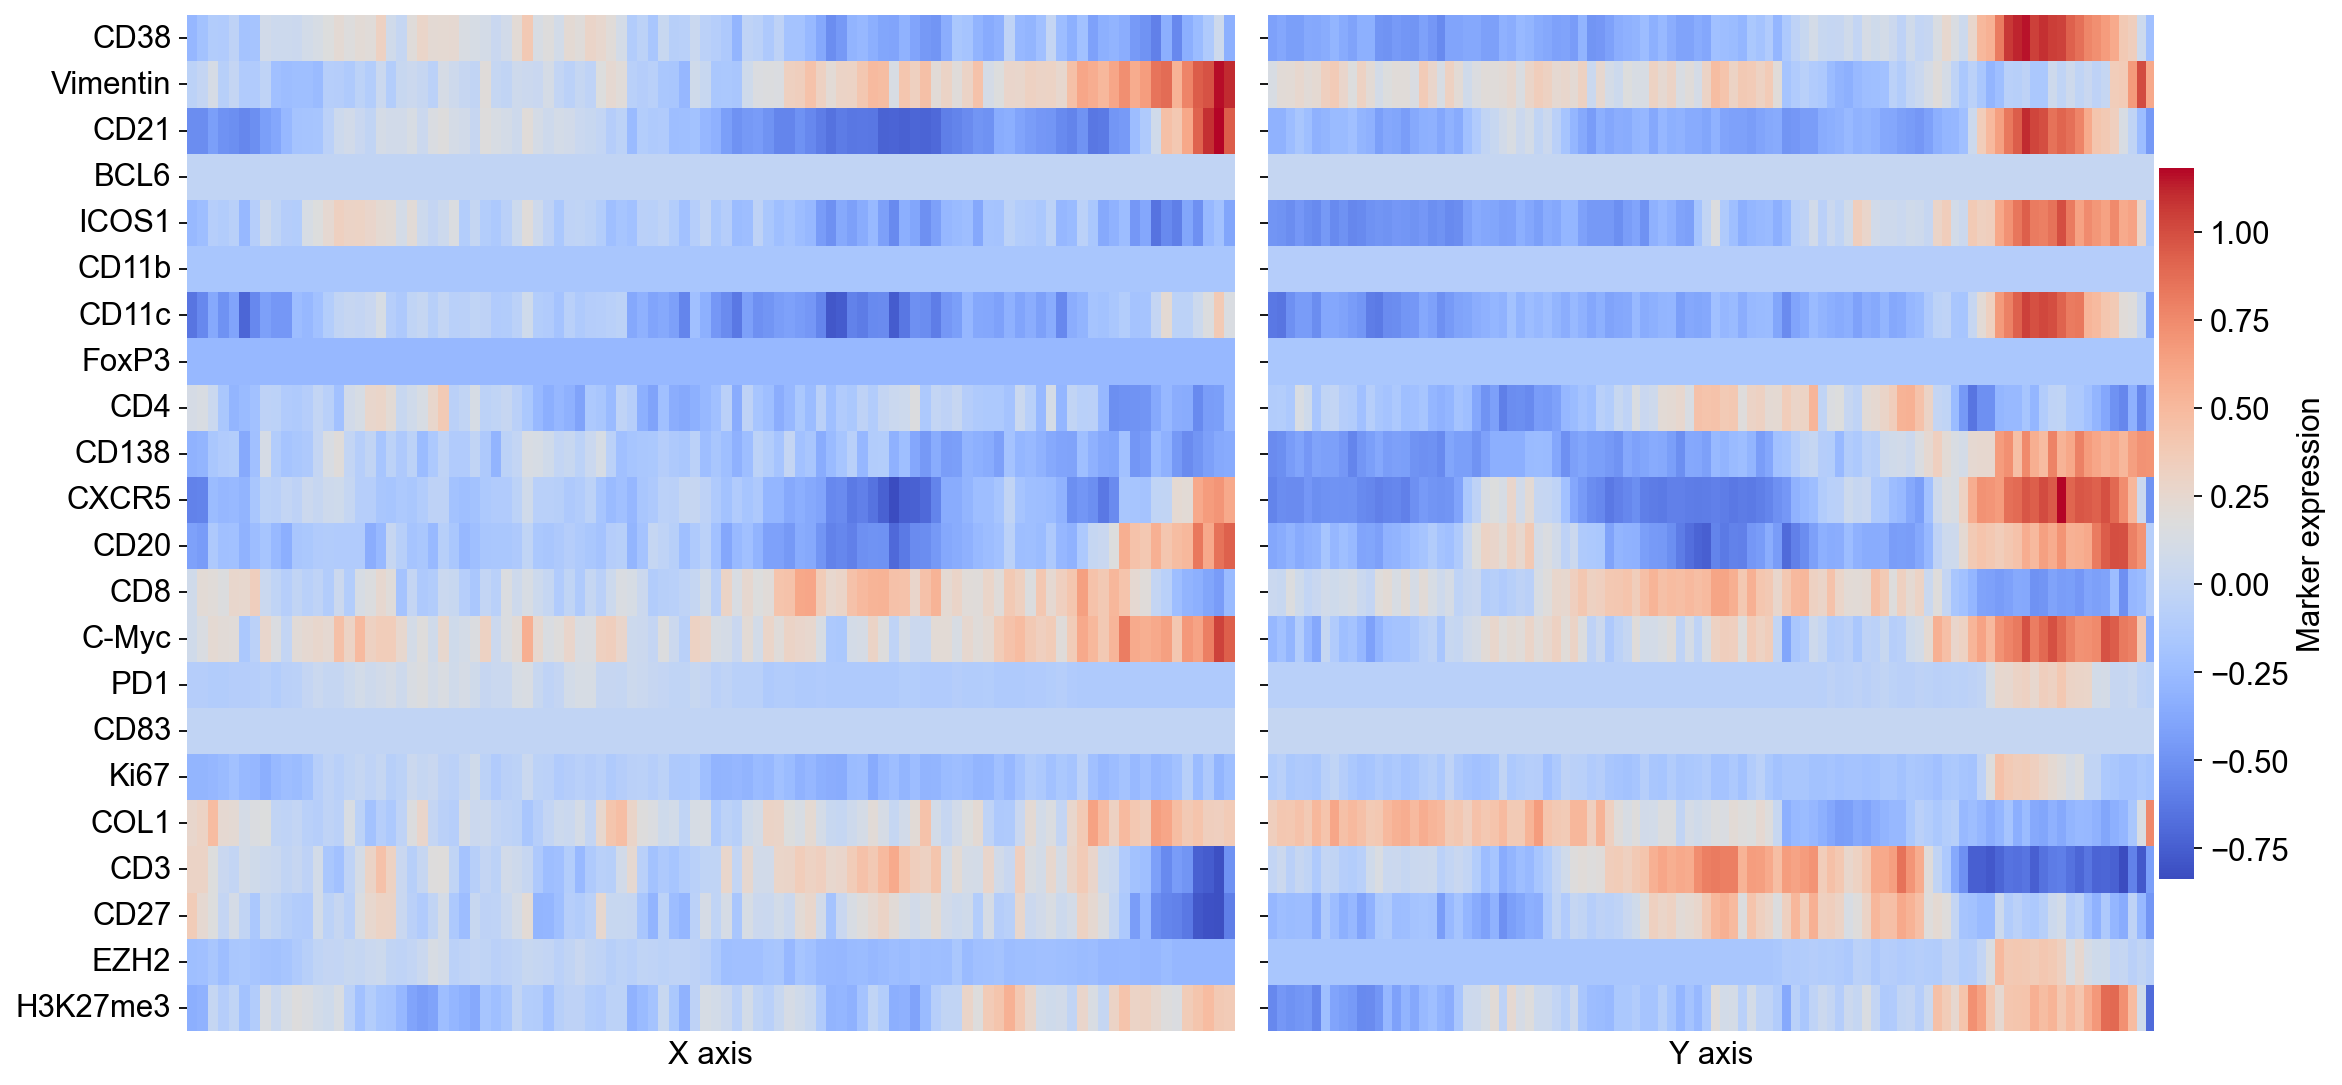

In [51]:
from sklearn.preprocessing import LabelEncoder
# Sort and define quantile cut 
df = df_intensity.sort_values(by=['X'])
df['X_sort'] = pd.qcut(df["X"], 100)
df['Y_sort'] = pd.qcut(df["Y"], 100)

# Create label for quantile 
LE = LabelEncoder()
df['X_sort'] = LE.fit_transform(df['X_sort'])
df_major = df[markers_list +['X_sort']]

df['Y_sort']= LE.fit_transform(df['Y_sort'])
df_minor = df[markers_list +['Y_sort']]

# Heatmap plot
df_major = df[markers_list + ['X_sort']]
df_major_mean = df_major.groupby('X_sort').mean()
df_major = df[markers_list + ['Y_sort']]
df_minor_mean = df_major.groupby('Y_sort').mean()

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,7))
ax1 = sns.heatmap(df_major_mean.T, ax=ax1, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar=False)
ax1.set(xlabel='X axis')
ax2 = sns.heatmap(df_minor_mean.T, ax=ax2, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar_kws={"label": "Marker expression", "pad": 0.004, "shrink": 0.7})
ax2.set(xlabel='Y axis')
plt.tight_layout()
plt.show()
